In [57]:
# imports

# data manipulation
import pandas as pd
import numpy as np

# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

In [4]:
# load data
train_file = './data/train.csv'
train_data = pd.read_csv(train_file)
train_data = pd.DataFrame(data=train_data)

test_file = './data/test.csv'
test_data = pd.read_csv(test_file)
test_data = pd.DataFrame(data=test_data)

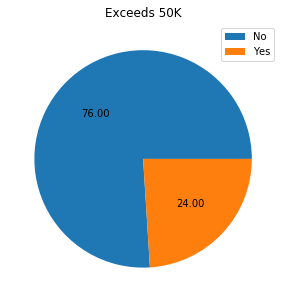

In [56]:
# Data Balance
exceeds50_graph = train_data['exceeds50K'].value_counts(sort=False).sort_index().plot(kind='pie', title='Exceeds 50K',  figsize=(5,5), autopct='%.2f', labels=None)
exceeds50_graph.set_ylabel("")
exceeds50_graph.legend(["No", "Yes"])

Text(0, 0.5, 'Number of samples')

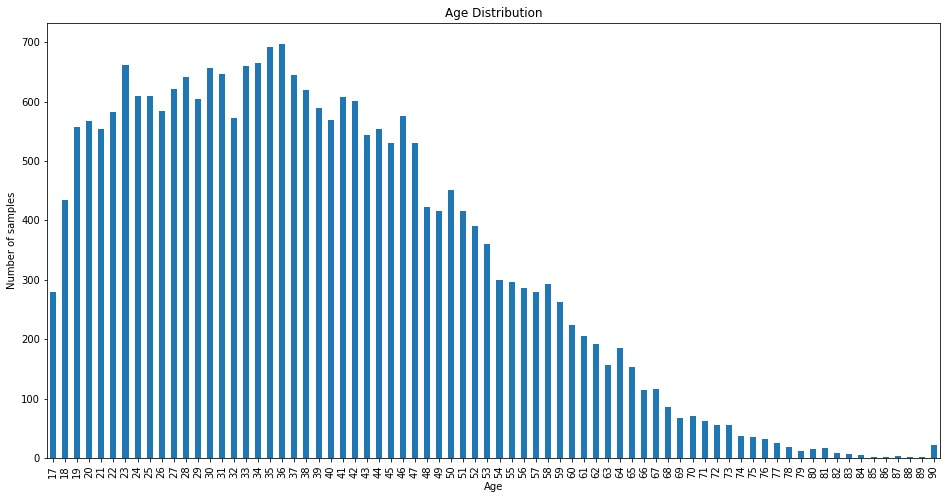

In [5]:
# Age Distribution
age_counts_graph = train_data['age'].value_counts(sort=False).sort_index().plot(kind='bar', title='Age Distribution',  figsize=(16,8))
age_counts_graph.set_xlabel("Age")
age_counts_graph.set_ylabel("Number of samples")

# Check for dirty data

> Brief inspection shows some missing data filled with " ?" values in columns:
- workclass
- occupation
- native-country

> As these are categorical values, we would have to remove them somehow

In [68]:
# Remove records with missing data (" ?") - CANT USE THIS BECAUSE TEST DATA ALSO HAS " ?" VALUES
def checkDirtyData(data):
    # workclass
    missing_data_workclass = data[data.workclass == ' ?']
    print("Percentage of missing work class data = " + "{:.2f}".format(missing_data_workclass.shape[0] / data.shape[0] * 100) + "%" )

    # occupation
    missing_data_occupation = data[data.occupation == ' ?']
    print("Percentage of missing occupation data = " + "{:.2f}".format(missing_data_occupation.shape[0] / data.shape[0] * 100) + "%" )

    # native-country
    missing_data_native_country = data[data['native-country'] == ' ?']
    print("Percentage of missing native country data = " + "{:.2f}".format(missing_data_native_country.shape[0] / data.shape[0] * 100) + "%" )

    # all
    missing_data = data[(data['workclass'] == ' ?') | (data['occupation'] == ' ?') | (data['native-country'] == ' ?')]
    print("Percentage of missing data = " + "{:.2f}".format(missing_data.shape[0] / data.shape[0] * 100) + "%" )
    return

print("Training data:")
checkDirtyData(train_data)
print("Test data:")
checkDirtyData(test_data)

Training data:
Percentage of missing work class data = 5.70%
Percentage of missing occupation data = 5.73%
Percentage of missing native country data = 1.68%
Percentage of missing data = 7.32%
Test data:
Percentage of missing work class data = 5.76%
Percentage of missing occupation data = 5.77%
Percentage of missing native country data = 1.83%
Percentage of missing data = 7.50%


In [63]:
# categorical
def preprocess(data):
    preprocessed_data = data.copy()
    
    # drop - too many categories and not very relevant intuitively
    preprocessed_data = preprocessed_data.drop(['native-country'], axis=1)
    # drop - duplicate of education-num
    preprocessed_data = preprocessed_data.drop(['education'], axis=1)
    preprocessed_data = pd.get_dummies(preprocessed_data)
    preprocessed_data = preprocessed_data.drop(['occupation_ ?'], axis=1)
    preprocessed_data = preprocessed_data.drop(['workclass_ ?'], axis=1)
    
    return preprocessed_data

preprocessed_train_data = preprocess(train_data)
preprocessed_test_data = preprocess(test_data)

x_train = preprocessed_train_data.drop('exceeds50K', axis=1)
y_train = preprocessed_train_data['exceeds50K']
#normalization
x_train_normalized = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train_normalized, columns=x_train.columns)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=True)

# Importance of features
> Run preliminary classification using GradientBoostingClassifier

> Objective - to confirm prevalent assumptions on importance of factors related to income

Training accuracy:  96.4
Test accuracy:  86.21
marital-status_ Married-civ-spouse       0.259970
education-num                            0.158528
capital-gain                             0.143007
fnlwgt                                   0.122280
age                                      0.086964
hours-per-week                           0.057191
capital-loss                             0.047085
occupation_ Exec-managerial              0.015454
workclass_ Self-emp-not-inc              0.009868
occupation_ Other-service                0.007545
occupation_ Prof-specialty               0.007527
relationship_ Husband                    0.006126
workclass_ Private                       0.006067
workclass_ Federal-gov                   0.005527
occupation_ Tech-support                 0.004814
occupation_ Sales                        0.004743
workclass_ Local-gov                     0.004157
sex_ Female                              0.004081
occupation_ Craft-repair                 0.003902
wor

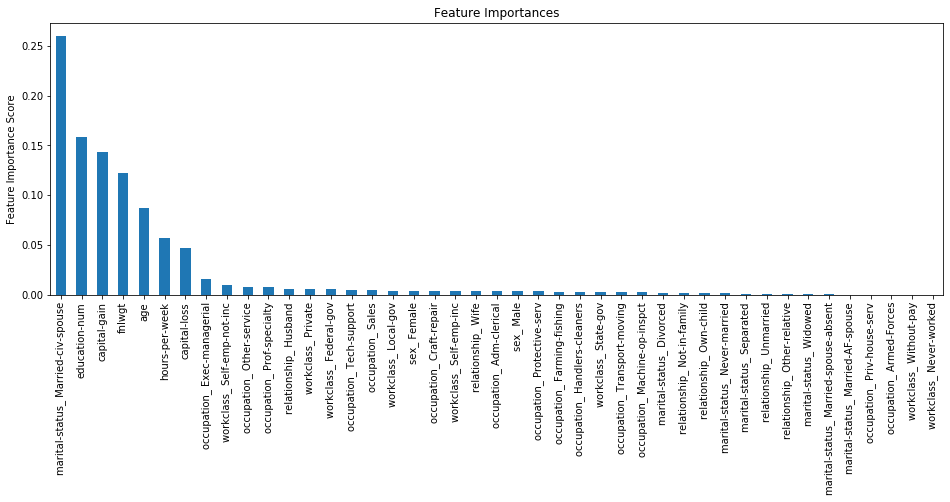

In [64]:
# CHECK FEATURE IMPORTANCE
classifier = GradientBoostingClassifier(max_depth=10, verbose=0)
model = classifier.fit(x_train, y_train)
y_pred = model.predict(x_train)
print("Training accuracy: ", str(round(f1_score(y_train, y_pred, average='weighted') * 100, 2)))
y_pred = model.predict(x_test)
print("Test accuracy: ", str(round(f1_score(y_test, y_pred, average='weighted') * 100, 2)))

predictors = [x for x in x_train.columns if x not in ['exceeds50K']]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)

feat_imp.plot(kind='bar', title='Feature Importances', figsize=(16,5))
plt.ylabel('Feature Importance Score')

print(feat_imp)